In [1]:
import pandas as pd
import numpy as np
import json
import requests
import zipfile
import io
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

from sklearn.linear_model import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

warnings.filterwarnings('ignore')

In [2]:
sns.set_style('whitegrid')

In [3]:
def extract_zip_files(zip_url, directory):
    request = requests.get(zip_url)
    zip_content = zipfile.ZipFile(io.BytesIO(request.content))
    zip_content.extractall(f"data/{directory}/")

In [4]:
def download_csvs():
    for year in range(2009, 2022):
        for month in range(1, 13):
            year = str(year)
            month = str(month)

            if len(month) == 1:
                month = '0' + month
                
            if pd.Timestamp(year + '-' + month) > pd.Timestamp.now():
                return

            scheduled_outage_zip_url = f"http://mis.nyiso.com/public/csv/schedlineoutages/{year}{month}01SCLineOutages_csv.zip"
            real_time_outage_zip_url = f"http://mis.nyiso.com/public/csv/realtimelineoutages/{year}{month}01RTLineOutages_csv.zip"
            load_forecast_zip_url = f"http://mis.nyiso.com/public/csv/isolf/{year}{month}01isolf_csv.zip"
            load_real_time_zip_url = f"http://mis.nyiso.com/public/csv/pal/{year}{month}01pal_csv.zip"
            weather_zip_url = f"http://mis.nyiso.com/public/csv/lfweather/{year}{month}01lfweather_csv.zip"

            directories = ['scheduled_outages', 'real_time_outages', 'forecast_load', 'real_time_load', 'weather']
            urls = [scheduled_outage_zip_url, real_time_outage_zip_url, load_forecast_zip_url, 
                    load_real_time_zip_url, weather_zip_url]

            for n in range(len(directories)):
                extract_zip_files(urls[n], directories[n])
        

In [5]:
def create_dfs(directories):
    dfs = {}
    scheduled_outage_csv = "SCLineOutages.csv"
    real_time_outage_csv = "RTLineOutages.csv"
    forecast_load_csv = "isolf.csv"
    real_time_load_csv = "pal.csv"
    weather_csv = "lfweather.csv"
    csvs = [scheduled_outage_csv, real_time_outage_csv, forecast_load_csv, real_time_load_csv, weather_csv]

    for n in range(len(directories)):
        directory = directories[n]
        df_days = []
        
        for year in range(2009, 2022):
            for month in range(1, 13):
                for day in range(1, 32):
                    year = str(year)
                    month = str(month)
                    day = str(day)

                    if len(month) == 1:
                        month = '0' + month

                    if len(day) == 1:
                        day = '0' + day

                    try:
                        file = pd.read_csv(f"data/{directory}/{year}{month}{day}{csvs[n]}")
                        df_days.append(file)
                    except:
                        pass

        df_days = pd.concat(df_days, ignore_index=True)
        dfs[directory] = df_days
    return dfs
            

In [ ]:
download_csvs()

In [ ]:
df_dict = create_dfs(directories=['scheduled_outages', 'real_time_outages', 'forecast_load', 'real_time_load', 'weather'])

In [ ]:
df_dict['scheduled_outages'].to_csv('data/nyiso_scheduled_outages.csv')
df_dict['real_time_outages'].to_csv('data/nyiso_real_time_outages.csv')
df_dict['forecast_load'].to_csv('data/nyiso_forecast_load.csv')
df_dict['real_time_load'].to_csv('data/nyiso_real_time_load.csv')
df_dict['weather'].to_csv('data/nyiso_weather.csv')

In [ ]:
scheduled_outages_df = df_dict['scheduled_outages'].copy(deep=True)
real_time_outages_df = df_dict['real_time_outages'].copy(deep=True)
forecast_load_df = df_dict['forecast_load'].copy(deep=True)
real_time_load_df = df_dict['real_time_load'].copy(deep=True)
weather_df = df_dict['weather'].copy(deep=True)

In [ ]:
real_time_load_df['Time Stamp'] = pd.to_datetime(real_time_load_df['Time Stamp'])

In [ ]:
capitl_load = real_time_load_df[real_time_load_df['Name'] == 'CAPITL']
centrl_load = real_time_load_df[real_time_load_df['Name'] == 'CENTRL']
dunwod_load = real_time_load_df[real_time_load_df['Name'] == 'DUNWOD']
genese_load = real_time_load_df[real_time_load_df['Name'] == 'GENESE']
hud_vl_load = real_time_load_df[real_time_load_df['Name'] == 'HUD VL']
longil_load = real_time_load_df[real_time_load_df['Name'] == 'LONGIL']
mhk_vl_load = real_time_load_df[real_time_load_df['Name'] == 'MHK VL']
millwd_load = real_time_load_df[real_time_load_df['Name'] == 'MILLWD']
nyc_load = real_time_load_df[real_time_load_df['Name'] == 'N.Y.C.']
north_load = real_time_load_df[real_time_load_df['Name'] == 'NORTH']
west_load = real_time_load_df[real_time_load_df['Name'] == 'WEST']

In [ ]:
load_dfs = [capitl_load.copy(deep=True), centrl_load.copy(deep=True), dunwod_load.copy(deep=True), 
            genese_load.copy(deep=True), hud_vl_load.copy(deep=True), longil_load.copy(deep=True),
            mhk_vl_load.copy(deep=True), millwd_load.copy(deep=True), nyc_load.copy(deep=True), 
            north_load.copy(deep=True), west_load.copy(deep=True)]

In [78]:
for df in load_dfs:
    df['hour_rolling_avg'] = df['Load'].rolling(12).mean()
    df['hour_rolling_min'] = df['Load'].rolling(12).min()
    df['hour_rolling_max'] = df['Load'].rolling(12).max()
    df['hour_rolling_std'] = df['Load'].rolling(12).std()
    
    df['three_hour_rolling_avg'] = df['Load'].rolling(36).mean()
    df['three_hour_rolling_min'] = df['Load'].rolling(36).min()
    df['three_hour_rolling_max'] = df['Load'].rolling(36).max()
    df['three_hour_rolling_std'] = df['Load'].rolling(36).std()
    
    df['six_hour_rolling_avg'] = df['Load'].rolling(72).mean()
    df['six_hour_rolling_max'] = df['Load'].rolling(72).max()
    df['six_hour_rolling_std'] = df['Load'].rolling(72).std()
    
    df['twelve_hour_rolling_avg'] = df['Load'].rolling(144).mean()
    df['twelve_hour_rolling_max'] = df['Load'].rolling(144).max()
    df['twelve_hour_rolling_std'] = df['Load'].rolling(144).std()

In [506]:
# would be cool to build in actuals - forecast as an outage prediction factor
forecast_load_df.head()

,Time Stamp,Capitl,Centrl,Dunwod,Genese,Hud Vl,Longil,Mhk Vl,Millwd,N.Y.C.,North,West,NYISO
0,01/01/2009 00:00,1124,1591,594,1003,1164,2464,758,347,5616,796,1589,17046
1,01/01/2009 01:00,1092,1567,574,954,1122,2337,727,327,5474,797,1535,16506
2,01/01/2009 02:00,1060,1529,547,913,1084,2218,701,309,5279,799,1482,15921
3,01/01/2009 03:00,1046,1508,530,892,1064,2137,685,306,5107,799,1455,15529
4,01/01/2009 04:00,1042,1508,522,890,1062,2109,684,304,5009,802,1451,15383


In [507]:
real_time_outages_df.head()

,Timestamp,PTID,Equipment Name,Outage Date/Time,Outage Date/Time,Outage Date/Time,first_word,Out Date
0,01/01/2009 00:02:17,13173,FARRAGUT345KV_11W______________CB,12/28/2008 03:30:00,NaN,2008-12-28 03:30:00,FARRAGUT,2008-12-28
1,01/01/2009 00:02:17,13269,RAMAPO 345KV_35-4500-5________CB,02/01/2005 00:00:00,NaN,2005-02-01 00:00:00,RAMAPO,2005-02-01
2,01/01/2009 00:02:17,13388,N.SCTLND345KV_R21______________CB,08/08/2008 21:21:00,NaN,2008-08-08 21:21:00,N.SCTLND,2008-08-08
3,01/01/2009 00:02:17,13565,RAMAPO 345KV_W72-2Y___________CB,12/01/2008 02:18:00,NaN,2008-12-01 02:18:00,RAMAPO,2008-12-01
4,01/01/2009 00:02:17,13661,PLATSBRG115KV_211B_____________CB,02/01/2005 00:00:00,NaN,2005-02-01 00:00:00,PLATSBRG,2005-02-01


In [508]:
scheduled_outages_df.head()

,Timestamp,PTID,Equipment Name,Scheduled Out Date/Time,Scheduled In Date/Time,first_word,Scheduled Out Date
0,01/01/2009 00:00:00,13173,FARRAGUT_345KV_11W,2008-12-28 03:30:47,01/25/2009 23:59:00,FARRAGUT,2008-12-28
1,01/01/2009 00:00:00,13269,RAMAPO___345KV_35-4500-5,2005-02-01 00:00:00,02/01/2015 00:00:00,RAMAPO,2005-02-01
2,01/01/2009 00:00:00,13661,PLATSBRG_115KV_211B,2005-02-01 00:00:00,02/01/2015 00:00:00,PLATSBRG,2005-02-01
3,01/01/2009 00:00:00,14220,GOWANUSN_138KV_GT 2-4,2005-02-01 00:00:00,02/01/2015 00:00:00,GOWANUSN,2005-02-01
4,01/01/2009 00:00:00,14255,SPRNBRK__345KV_CS-49_BYPASS,2005-02-01 00:00:00,02/01/2015 00:00:00,SPRNBRK,2005-02-01


In [90]:
scheduled_outages_df = scheduled_outages_df.drop_duplicates(
    ['PTID','Equipment Name','Scheduled Out Date/Time'])

In [104]:
real_time_outages_df['Outage Date/Time'] = real_time_outages_df['Outage Date/Time'].fillna(real_time_outages_df[' Outage Date/Time '])
real_time_outages_df['Outage Date/Time'] = real_time_outages_df['Outage Date/Time'].fillna(real_time_outages_df[' Outage Date/Time'])
real_time_outages_df = real_time_outages_df.drop_duplicates(['PTID', 'Equipment Name', 'Outage Date/Time'])


In [105]:
real_time_outages_df['Outage Date/Time'] = pd.to_datetime(real_time_outages_df['Outage Date/Time'])
scheduled_outages_df['Scheduled Out Date/Time'] = pd.to_datetime(scheduled_outages_df['Scheduled Out Date/Time'])

<ipython-input-105-aacc0ce0e0b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_time_outages_df['Outage Date/Time'] = pd.to_datetime(real_time_outages_df['Outage Date/Time'])
<ipython-input-105-aacc0ce0e0b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scheduled_outages_df['Scheduled Out Date/Time'] = pd.to_datetime(scheduled_outages_df['Scheduled Out Date/Time'])


In [191]:
real_time_outages_df['first_word'] = [
    re.split(r'[_123456789 ]', real_time_outages_df['Equipment Name'].loc[x])[0] 
    for x in real_time_outages_df.index]

scheduled_outages_df['first_word'] = [
    re.split(r'[_123456789 ]', scheduled_outages_df['Equipment Name'].loc[x])[0] 
    for x in scheduled_outages_df.index]

<ipython-input-191-3b0dc8d63503>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_time_outages_df['first_word'] = [
<ipython-input-191-3b0dc8d63503>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scheduled_outages_df['first_word'] = [


In [170]:
scheduled_outages_df['Scheduled Out Date'] = scheduled_outages_df['Scheduled Out Date/Time'].dt.date
real_time_outages_df['Out Date'] = real_time_outages_df['Outage Date/Time'].dt.date

<ipython-input-170-0849dffb324f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scheduled_outages_df['Scheduled Out Date'] = scheduled_outages_df['Scheduled Out Date/Time'].dt.date
<ipython-input-170-0849dffb324f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_time_outages_df['Out Date'] = real_time_outages_df['Outage Date/Time'].dt.date


In [193]:
merged_outage_df = real_time_outages_df.merge(scheduled_outages_df[['Scheduled Out Date', 'first_word']], how='left', left_on=['first_word', 'Out Date'],
                                              right_on=['first_word', 'Scheduled Out Date'])

In [196]:
merged_outage_df = merged_outage_df.drop_duplicates()
unscheduled_outage_df = merged_outage_df[merged_outage_df['Scheduled Out Date'].isnull()]

In [235]:
outage_counts = pd.Series(unscheduled_outage_df.groupby('Out Date')['PTID'].count(), 
                          index=real_time_load_df['Time Stamp'].dt.date.unique())
outage_counts = outage_counts.fillna(0)

### Unscheduled Outage EDA

* The # of unscheduled outages has generally gone down since 2009 but has been increasing slowly since 2017.
* Outages occur most frequently in the morning, between 6-10am and least frequently during peak hours of 5-8pm
* Outages occur most frequently in the Spring (March through May)

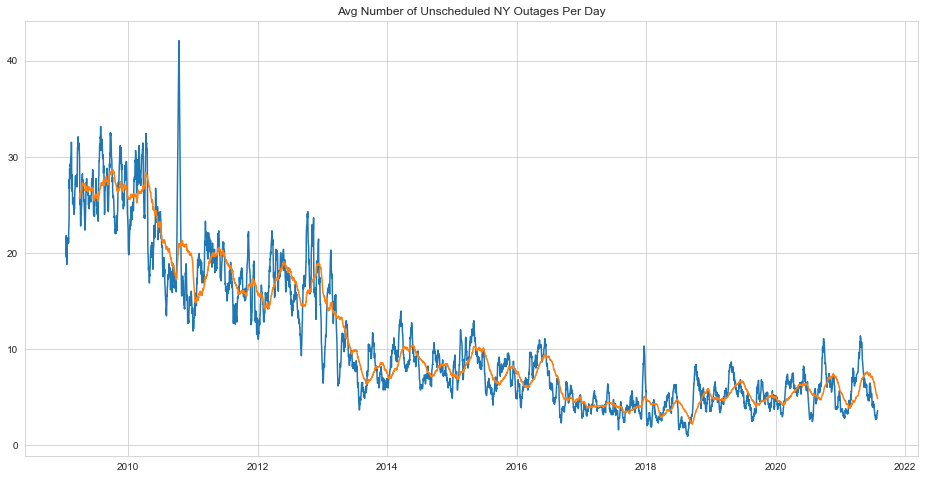

In [437]:
outage_counts.rolling(14).mean().plot(figsize=[16,8])
outage_counts.rolling(90).mean().plot(figsize=[16,8])
plt.title('Avg Number of Unscheduled NY Outages Per Day')
plt.show()

In [233]:
unscheduled_outage_df['hour'] = unscheduled_outage_df['Outage Date/Time'].dt.hour
unscheduled_outage_df['month'] = unscheduled_outage_df['Outage Date/Time'].dt.month

<ipython-input-233-7e9c2c80e275>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unscheduled_outage_df['hour'] = unscheduled_outage_df['Outage Date/Time'].dt.hour
<ipython-input-233-7e9c2c80e275>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unscheduled_outage_df['month'] = unscheduled_outage_df['Outage Date/Time'].dt.month


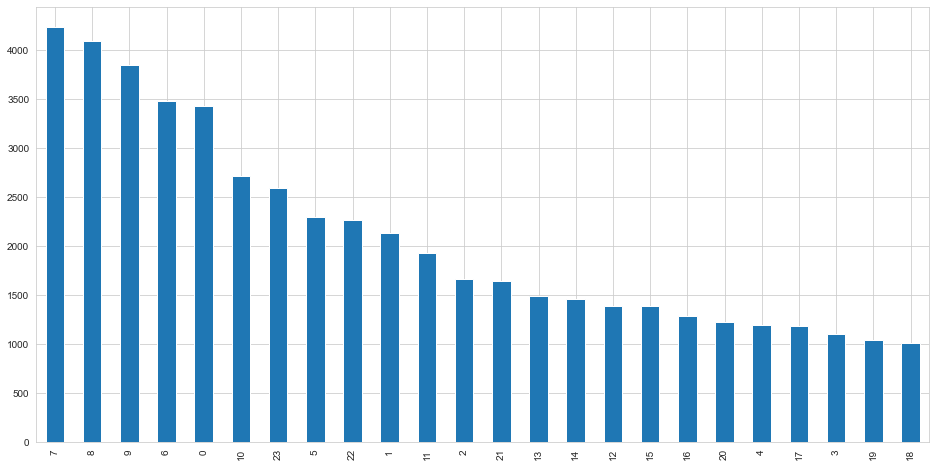

In [231]:
unscheduled_outage_df['hour'].value_counts().plot.bar(figsize=[16,8])
plt.show()

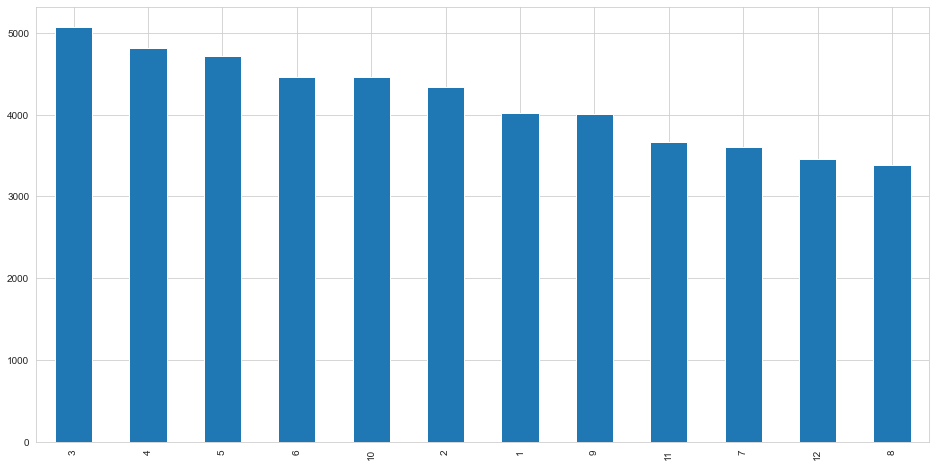

In [234]:
unscheduled_outage_df['month'].value_counts().plot.bar(figsize=[16,8])
plt.show()

In [204]:
# because we don't have intra-New York granularity of the outage data ( :( ), will merge the 11 districts back into one dataframe
# then merge the outage info in

In [374]:
full_load_df['month'] = full_load_df['Time Stamp'].dt.month
full_load_df['week'] = full_load_df['Time Stamp'].dt.week
full_load_df['hour'] = full_load_df['Time Stamp'].dt.hour

full_load_df['month'] = full_load_df['month'].astype(str)
full_load_df['week'] = full_load_df['week'].astype(str)
full_load_df['hour'] = full_load_df['hour'].astype(str)

full_load_df = pd.concat([full_load_df, pd.get_dummies(full_load_df[['month', 'week', 'hour']])], axis=1)

In [362]:
for load_df in load_dfs:
    load_df.columns = ['Time Stamp', 'Time Zone', 'Name', 'PTID'] + \
                      [load_df['Name'].iloc[0] + '_' + x for x in load_df.columns[-15:]]
    load_df = load_df.drop(['Time Zone', 'Name', 'PTID'], axis=1)
    
full_load_df = load_dfs[0]

for load_df in load_dfs[1:]:
    full_load_df = full_load_df.merge(load_df, how='left', on='Time Stamp')

In [364]:
# rounding timestamps to every 5th minute to be able to merge // thanks stackoverflow 
# https://stackoverflow.com/questions/24479577/pandas-timestamp-index-rounding-to-the-nearest-5th-minute

ns5min = 5 * 60 * 1000000000 # 5 minutes in nanoseconds 
unscheduled_outage_df['Outage Date/Time Rounded'] = pd.to_datetime(((unscheduled_outage_df['Outage Date/Time'].astype(np.int64) // ns5min + 1 ) * ns5min))

In [365]:
outages_per_5min = pd.DataFrame(unscheduled_outage_df.groupby('Outage Date/Time Rounded').count()['Timestamp']).reset_index()
outages_per_5min.columns = ['Outage Date/Time Rounded', 'outages']

In [367]:
full_load_df = full_load_df.merge(outages_per_5min[['Outage Date/Time Rounded', 'outages']], how='left', left_on='Time Stamp', right_on='Outage Date/Time Rounded')

In [368]:
full_load_df['outages'] = full_load_df['outages'].fillna(0)

### because of the imbalance in the dataset, I'll make this a classification problem instead of a regression problem: predicting whether a blackout occurs during this 5min period as opposed to the # of blackouts that occur

In [370]:
full_load_df['outages'].value_counts()

0.0     1567627
1.0       45275
2.0        7538
3.0         929
4.0         333
5.0          80
6.0          48
7.0          16
8.0           5
9.0           3
12.0          2
26.0          1
40.0          1
32.0          1
28.0          1
33.0          1
36.0          1
35.0          1
Name: outages, dtype: int64

In [372]:
full_load_df['has_outage'] = full_load_df['outages'].clip(upper=1)

In [373]:
regr = LogisticRegressionCV(class_weight='balanced')

In [378]:
delete_columns = ['Time Zone_x', 'Name_x', 'PTID_x', 'Outage Date/Time Rounded', 
                  'Time Zone_y', 'Name_y', 'PTID_y', 'Time Zone', 'Name', 'PTID']

In [379]:
full_load_df = full_load_df.drop(delete_columns, axis=1)
full_load_df = full_load_df.loc[:,~full_load_df.columns.duplicated()]
full_load_df = full_load_df.dropna(how='any')

In [385]:
non_training_columns = ['Time Stamp', 'outages', 'has_outage']

y = full_load_df['has_outage']
X = full_load_df.drop(non_training_columns, axis=1)

X = X.reset_index()
X = X.drop(['index'], axis=1)

y = y.reset_index()
y = y.drop(['index'], axis=1)
y = y['has_outage']

In [454]:
outage_corr = full_load_df.corr()['outages']

In [397]:
starter_features = outage_corr.sort_values().index[::10]

### first pass model: starter features (every 10th when sorting by correlation with # of outages)

In [398]:
X = X[starter_features]

In [399]:
regr.fit(X, y)

LogisticRegressionCV(class_weight='balanced')

In [446]:
predictions = regr.predict_proba(X)
outage_probabilities = [predictions[x][1] for x in range(len(predictions))]

In [410]:
metrics.roc_auc_score(y, outage_probabilities)

0.6615784248431963

### second pass model: iterating through adding hour of day and month of day features, to no improvement

In [439]:
y = full_load_df['has_outage']
X = full_load_df[list(starter_features) + [x for x in full_load_df if ('hour_' in x) and len(x) < 20]] # month and hour didn't do anything

In [440]:
regr.fit(X, y)

LogisticRegressionCV(class_weight='balanced')

In [441]:
predictions = regr.predict_proba(X)
outage_probabilities = [predictions[x][1] for x in range(len(predictions))]
metrics.roc_auc_score(y, outage_probabilities)

0.661262459129687

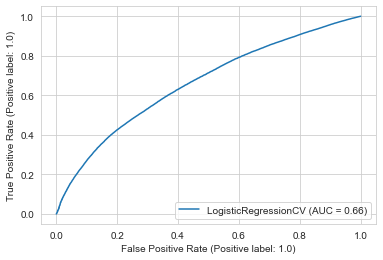

In [453]:
metrics.plot_roc_curve(regr, X, y)
plt.show()

In [457]:
outage_corr.sort_values()

CAPITL_CAPITL_CAPITL_three_hour_rolling_min    -0.058532
CAPITL_CAPITL_CAPITL_hour_rolling_min          -0.049118
CAPITL_CAPITL_CAPITL_six_hour_rolling_avg      -0.048422
DUNWOD_DUNWOD_DUNWOD_three_hour_rolling_min    -0.047512
CAPITL_CAPITL_CAPITL_twelve_hour_rolling_avg   -0.045745
                                                  ...   
CENTRL_CENTRL_CENTRL_three_hour_rolling_std     0.066632
MHK VL_MHK VL_MHK VL_three_hour_rolling_std     0.066775
N.Y.C._N.Y.C._N.Y.C._three_hour_rolling_std     0.074567
has_outage                                      0.877651
outages                                         1.000000
Name: outages, Length: 256, dtype: float64

### third pass model: trying out random forest classifier

In [505]:
clf = RandomForestClassifier(max_depth=4, class_weight='balanced')
rf_predictions = pd.DataFrame(columns=[0, 1], index=X.index)

for train_index , test_index in KFold(5, random_state=None).split(X):
    print(len(train_index))
    X_train , X_test = X.loc[train_index], X.loc[test_index]
    y_train , y_test = y.loc[train_index] , y.loc[test_index]
     
    clf.fit(X_train,y_train)
    rf_predictions.loc[test_index] = clf.predict_proba(X_test)

1294094
1294094
1294094
1294095
1294095


In [509]:
metrics.roc_auc_score(y.astype(int), rf_predictions[1])

0.5371622082840352

In [494]:
weather_df

,Forecast Date,Vintage Date,Vintage,Station ID,Max Temp,Min Temp,Max Wet Bulb,Min Wet Bulb,
0,01/01/2009,01/01/2009,Forecast,ALB,18,6,14,4,NaN
1,01/01/2009,01/01/2009,Forecast,ART,15,-2,13,-2,NaN
2,01/01/2009,01/01/2009,Forecast,BGM,16,7,13,6,NaN
3,01/01/2009,01/01/2009,Forecast,BUF,25,11,21,10,NaN
4,01/01/2009,01/01/2009,Forecast,ELM,24,9,19,8,NaN
...,...,...,...,...,...,...,...,...,...
441254,07/27/2021,07/28/2021,Forecast,ROC,76,63,65,60,NaN
441255,07/27/2021,07/28/2021,Forecast,SLK,71,52,59,52,NaN
441256,07/27/2021,07/28/2021,Forecast,SWF,77,66,68,64,NaN
441257,07/27/2021,07/28/2021,Forecast,SYR,79,65,67,62,NaN


### non-AUC results breakdown

In [515]:
full_load_df['outage_probability'] = pd.Series(outage_probabilities, index=full_load_df.index)

In [521]:
full_load_df['least_likely_25pct'] = full_load_df['outage_probability'] < full_load_df['outage_probability'].quantile(.25)
full_load_df['most_likely_10pct'] = full_load_df['outage_probability'] > full_load_df['outage_probability'].quantile(.9)
full_load_df['most_likely_5pct'] = full_load_df['outage_probability'] > full_load_df['outage_probability'].quantile(.95)

In [525]:
full_load_df['most_likely_1pct'] = full_load_df['outage_probability'] > full_load_df['outage_probability'].quantile(.99)

In [522]:
full_load_df.groupby('most_likely_5pct')['outages'].mean()

most_likely_5pct
False    0.036383
True     0.117642
Name: outages, dtype: float64

In [523]:
full_load_df.groupby('most_likely_10pct')['outages'].mean()

most_likely_10pct
False    0.033512
True     0.102849
Name: outages, dtype: float64

In [524]:
full_load_df.groupby('least_likely_25pct')['outages'].mean()

least_likely_25pct
False    0.047535
True     0.019179
Name: outages, dtype: float64

In [527]:
full_load_df['outages'].mean()

0.04044589019162744